In [ ]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
# config = tf.ConfigProto()
# config.gpu_options.allocator_type = 'BFC' #A "Best-fit with coalescing" algorithm, simplified from a version of dlmalloc.
# config.gpu_options.per_process_gpu_memory_fraction = 0.3
# config.gpu_options.allow_growth = True
# set_session(tf.Session(config=config)) 

## LIMIT GPU USAGE
config = tf.ConfigProto(log_device_placement=True)  
config.gpu_options.allow_growth = True  # don't pre-allocate memory; allocate as-needed
config.gpu_options.per_process_gpu_memory_fraction = 0.95  # limit memory to be allocated
set_session(tf.Session(config=config)) # create sess w/ above settings
print(tf.test.is_built_with_cuda())

Using TensorFlow backend.


True


In [ ]:
import tensorflow as tf
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


In [ ]:
# keras example imports
from keras.models import load_model
 
## extra imports to set GPU options
import tensorflow as tf
from keras import backend as k

k.get_session().close()
###################################
# TensorFlow wizardry
config = tf.ConfigProto()
 
# Don't pre-allocate memory; allocate as-needed
config.gpu_options.allow_growth = True
 
# Only allow a total of half the GPU memory to be allocated
config.gpu_options.per_process_gpu_memory_fraction = 0.95
 
# Create a session with the above options specified.
k.tensorflow_backend.set_session(tf.Session(config=config))
###################################
print(tf.test.is_built_with_cuda())

True


https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/
https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
https://machinelearningmastery.com/models-sequence-prediction-recurrent-neural-networks/
https://machinelearningmastery.com/how-to-develop-rnn-models-for-human-activity-recognition-time-series-classification/

In [ ]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import os
import numpy as np
from tabulate import tabulate
 
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 
# load dataset
dirpath = os.getcwd()
dataset = read_csv(dirpath + '/datasetForLSTM/60_5%_Allcombine.csv', header=0, index_col=0)
values = dataset.values

# specify the number of lag hours
n_mins = 3
n_features = 6
# frame as supervised learning
reframed = series_to_supervised(values, n_mins, 1)
print(reframed.head())

   var1(t-3)  var2(t-3)  var3(t-3)  var4(t-3)  var5(t-3)  var6(t-3)  \
3        0.0        0.0        0.0        0.0        0.0        0.0   
4        0.0        0.0        0.0        0.0        0.0        0.0   
5        0.0        0.0        0.0        0.0        0.0        0.0   
6        0.0        0.0        0.0        0.0        0.0        0.0   
7        0.0        0.0        0.0        0.0        0.0        0.0   

   var1(t-2)  var2(t-2)  var3(t-2)  var4(t-2)  ...  var3(t-1)  var4(t-1)  \
3        0.0        0.0        0.0        0.0  ...        0.0        0.0   
4        0.0        0.0        0.0        0.0  ...        0.0        0.0   
5        0.0        0.0        0.0        0.0  ...        0.0        0.0   
6        0.0        0.0        0.0        0.0  ...        0.0        0.0   
7        0.0        0.0        0.0        0.0  ...        0.0        0.0   

   var5(t-1)  var6(t-1)  var1(t)  var2(t)  var3(t)  var4(t)  var5(t)  var6(t)  
3        0.0        0.0        0    

In [ ]:
# drop columns we don't want to predict
reframed.drop(reframed.columns[[18,19,20,21,22]], axis=1, inplace=True)
print(reframed.head())

   var1(t-3)  var2(t-3)  var3(t-3)  var4(t-3)  var5(t-3)  var6(t-3)  \
3        0.0        0.0        0.0        0.0        0.0        0.0   
4        0.0        0.0        0.0        0.0        0.0        0.0   
5        0.0        0.0        0.0        0.0        0.0        0.0   
6        0.0        0.0        0.0        0.0        0.0        0.0   
7        0.0        0.0        0.0        0.0        0.0        0.0   

   var1(t-2)  var2(t-2)  var3(t-2)  var4(t-2)  var5(t-2)  var6(t-2)  \
3        0.0        0.0        0.0        0.0        0.0        0.0   
4        0.0        0.0        0.0        0.0        0.0        0.0   
5        0.0        0.0        0.0        0.0        0.0        0.0   
6        0.0        0.0        0.0        0.0        0.0        0.0   
7        0.0        0.0        0.0        0.0        0.0        0.0   

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  var6(t)  
3        0.0        0.0        0.0        0.0        0.0        0.0

In [ ]:
# split into train and test sets
values = reframed.values
n_train_hours =80 * 181
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

# temp = train.tolist()
# temp = DataFrame(temp)
# temp.to_csv(dirpath + '/train.csv',index=False)

# temp = test.tolist()
# temp = DataFrame(temp)
# temp.to_csv(dirpath + '/test.csv',index=False)

In [ ]:
# split into input and outputs
n_obs = n_mins * n_features
train_X, train_y = train[:, :n_obs], train[:, -1]
test_X, test_y = test[:, :n_obs], test[:, -1]

In [ ]:
# print(tabulate(test_X, headers=['test_X'], tablefmt='orgtbl'))

In [ ]:
# temp = test_y.tolist()
# temp = DataFrame(temp)
# temp

(14480, 18) 14480 (14480,)
(14480, 3, 6) (14480,) (3617, 3, 6) (3617,)
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


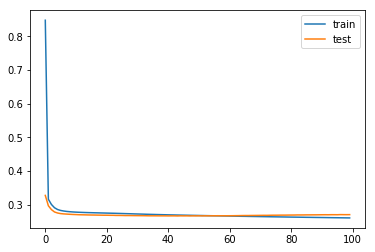

In [ ]:
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_mins, n_features))
test_X = test_X.reshape((test_X.shape[0], n_mins, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
 
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=20, validation_data=(test_X, test_y), verbose=0, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
# make a prediction
yhat = model.predict(test_X)

In [ ]:
yhat = [np.round(num) for num in yhat]
# print(tabulate(yhat, headers=['yhat'], tablefmt='orgtbl'))

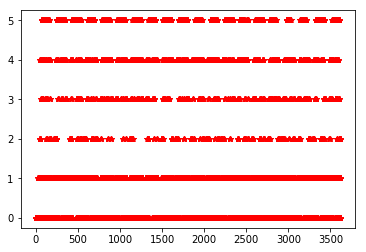

In [ ]:
pyplot.plot(test,  'r*',label='actual')
pyplot.show()

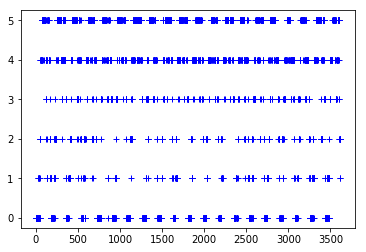

In [ ]:
pyplot.plot(yhat, 'b+',label='predict')
pyplot.show()